In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

# Local import 

from spectra.py_spectra import *

# Two levels that are used to create mean analysis

analysis_levels  = [6,17,28]
analysis_levels  = [10,25]

# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])


# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def open_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#-----------------------------------------------------------------
def run_spectral_analysis(in_dir, out_dir, day, nam = False):

    hrrr_dir  = str(os.path.join(in_dir, day, "hrrr"))
    rrfs0_dir = str(os.path.join(in_dir, day, "ctrl"))
    rrfs1_dir = str(os.path.join(in_dir, day, "nord3"))
    
    if nam == True:
        print("NAM analysis requested, will be added\n")
        nam_dir = str(os.path.join(in_dir, day, "nam"))

    # Open data sets

    hrrr  = open_mfdataset_list(hrrr_dir , "region_*.nc")
    rrfs0 = open_mfdataset_list(rrfs0_dir, "region_*.nc")
    rrfs1 = open_mfdataset_list(rrfs1_dir, "region_*.nc")
    
    if nam == True:
        nam = open_mfdataset_list(nam_dir, "region_*.nc")

    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these five levels are averaged together

        klevels = [k-2, k-1, k, k+1, k+2]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

        hrrr_u = np.nan_to_num(hrrr.U.isel(nz=klevels).values).astype('float64')
        hrrr_v = np.nan_to_num(hrrr.V.isel(nz=klevels).values).astype('float64')
        hrrr_w = np.nan_to_num(hrrr.W.isel(nz=klevels).values).astype('float64')

        hrrr_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)


        rrfs0_u = np.nan_to_num(rrfs0.U.isel(nz=klevels).values).astype('float64')
        rrfs0_v = np.nan_to_num(rrfs0.V.isel(nz=klevels).values).astype('float64')
        rrfs0_w = np.nan_to_num(rrfs0.W.isel(nz=klevels).values).astype('float64')

        rrfs0_tk2 = 0.5*(rrfs0_u**2 + rrfs0_v**2)

        rrfs1_u = np.nan_to_num(rrfs1.U.isel(nz=klevels).values).astype('float64')
        rrfs1_v = np.nan_to_num(rrfs1.V.isel(nz=klevels).values).astype('float64')
        rrfs1_w = np.nan_to_num(rrfs1.W.isel(nz=klevels).values).astype('float64')

        rrfs1_tk2 = 0.5*(rrfs1_u**2 + rrfs1_v**2)
        
        if nam == True:

            nam_u = np.nan_to_num(nam.U.isel(nz=klevels).values).astype('float64')
            nam_v = np.nan_to_num(nam.V.isel(nz=klevels).values).astype('float64')
            nam_w = np.nan_to_num(nam.W.isel(nz=klevels).values).astype('float64')

            nam_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)

        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        ylim    = [0.0001,1.0e2]
        axis    = 0
        func    = get_spectra2D_POWSPEC
        func    = get_spectra2D_AVG
        PS_only = True

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        plot_spectra(rrfs0_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=ylim, LinsborgSlope=True, PSonly=PSonly)
        plot_spectra(rrfs1_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim, PSonly=PSonly)
        
        if nam == True:
            plot_spectra(nam_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='green', ylim=ylim, PSonly=PSonly)
            plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red\nNAM:green', ptitle = 'W Pow_Spec', ylim=ylim, PSonly=PSonly)
        else:
            plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'W Pow_Spec', ylim=ylim, PSonly=PSonly)
            
        ax1 = fig.add_subplot(gs[0, 1])
        ylim = [1.,1.0e7]

        plot_spectra(rrfs0_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=ylim, LinsborgSlope=True, PSonly=PSonly)
        plot_spectra(rrfs1_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim, PSonly=PSonly)

        if nam == True:
            plot_spectra(nam_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='green', ylim=ylim, PSonly=PSonly)
            plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red\nNAM:green', ptitle = 'W Pow_Spec', ylim=ylim, PSonly=PSonly)
        else:
            plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'Hor. TKE Pow_Spec', ylim=ylim, PSonly=PSonly)

        plt.suptitle("W-Spectra Avg Over all Case Days \n Pressure Level: %d hPa" % (plevels[k]/100), fontsize=20)

        plt.savefig("%s/spectra_%s_%3.3dhPa.png" % (out_dir, 'W-Spectra', plevels[k]/100),bbox_inches='tight', dpi=300)


In [18]:
in_dir  = "~/CAM_case_studies"
out_dir = "/Users/Louis.Wicker/CAM_analysis_tools"
day     = ["2021052612"]

for d in day:
    print("Running day:  %s\n" % d)
    ret = run_spectral_analysis(in_dir, out_dir, d)

Running day:  2021052612



OSError: no files to open


====> Begin processing runs


----> Processing run: hrrr for day:  2019071918 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: ctrl for day:  2019071918 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: nord3 for day:  2019071918 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: hrrr for day:  2020081006 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: ctrl for day:  2020081006 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that sp

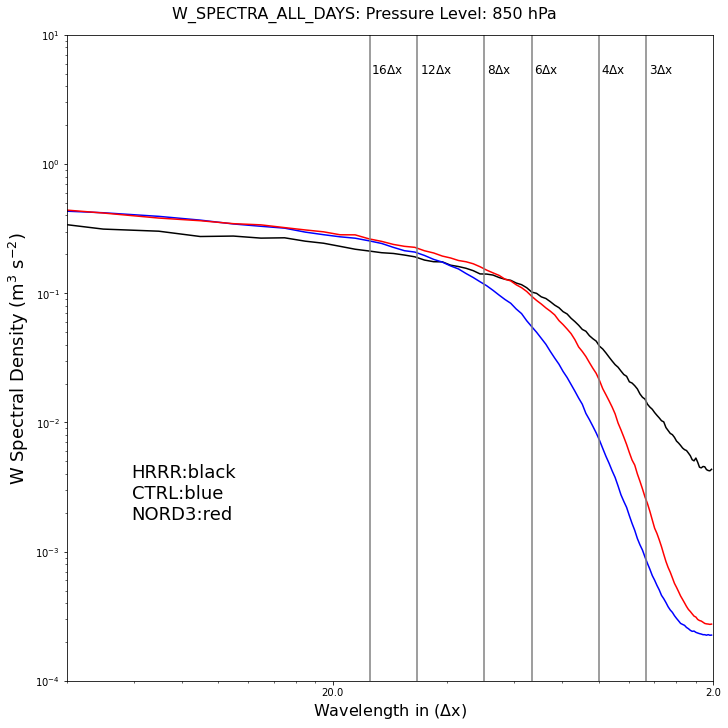

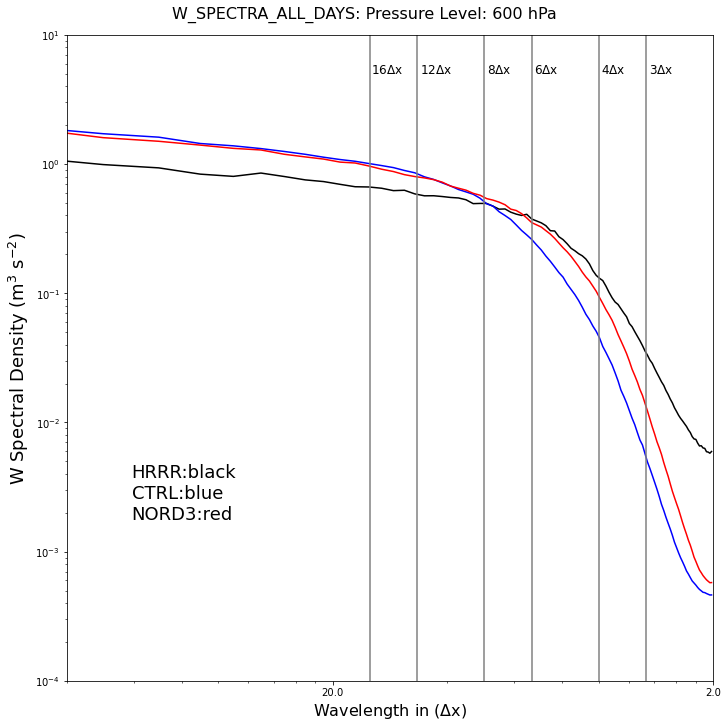

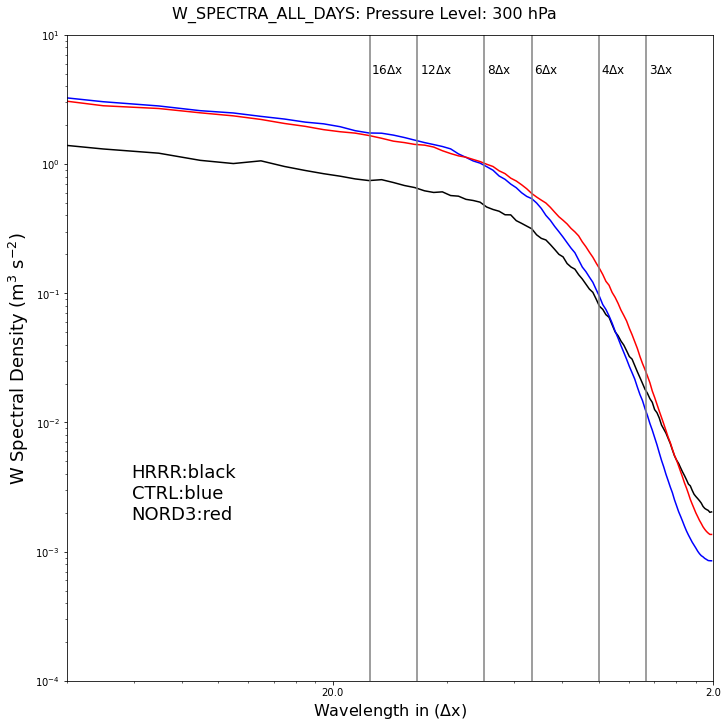

In [22]:
# Input data sets....

from input_default import input_all as input_config
import matplotlib.ticker as mticker

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

input_dir  = input_config["input_dir"]
output_dir = input_config["output_dir"]
ncases     = len(input_config["cases"])

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"hrrr":[], 
             "ctrl":[],
             "nam":[],
             "nord3":[]}

avg_data = {"hrrr" :np.zeros((ncases,avg_grid.shape[0],)), 
            "ctrl" :np.zeros((ncases,avg_grid.shape[0],)),
            "nam"  :np.zeros((ncases,avg_grid.shape[0],)),
            "nord3":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_AVG
axis = None

delta = False
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

analysis_levels  = [6,16,28]

for k in analysis_levels:
    for n, day in enumerate(input_config["cases"]):
        for run in input_config["cases"][day]:

            print("\n----> Processing run: %s for day:  %s \n" % (run,day))
            run_dir = str(os.path.join(input_dir, day, run))
            out_dir = str(os.path.join(output_dir, day, run))

            # Open data set

            data = open_mfdataset_list(run_dir , "region_*.nc")
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-2, k-1, k, k+1, k+2]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_w = np.nan_to_num(data.W.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = plot_spectra(data_w, func=func, ret_Data=True, no_Plot=True, print_info=False)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])


# Now post the runs....

    legend='HRRR:black\nCTRL:blue\nNORD3:red'

    avg_hrrr  = avg_data['hrrr'].mean(axis=0)
    avg_ctrl  = avg_data['ctrl'].mean(axis=0)
    avg_nord3 = avg_data['nord3'].mean(axis=0)

    avg_nam   = avg_data['nam'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_nord = avg_nord3[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_nord,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_ctrl,  color='blue')
    axes.loglog(avg_grid, avg_nord3, color='red')
    axes.loglog(avg_grid, avg_nam, color='green')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [0.0001,10.0]
    
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5.

    xoffset = [0.01, 0.0075, 0.005, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([3.0, 4.0, 6.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"W Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    # plt.title(ptitle, fontsize=18)

    plt.suptitle("W_SPECTRA_ALL_DAYS: Pressure Level: %d hPa" % (plevels[k]/100), fontsize=16)

    plt.savefig("%s/spectra_%s_%3.3dhPa.png" % ('/work/wicker/CAM_analysis_tools', 'W_ALL', plevels[k]/100),bbox_inches='tight',dpi=300)



In [16]:
avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)
print(avg_grid)

[0.005      0.01494949 0.02489899 0.03484848 0.04479798 0.05474747
 0.06469697 0.07464646 0.08459596 0.09454545 0.10449495 0.11444444
 0.12439394 0.13434343 0.14429293 0.15424242 0.16419192 0.17414141
 0.18409091 0.1940404  0.2039899  0.21393939 0.22388889 0.23383838
 0.24378788 0.25373737 0.26368687 0.27363636 0.28358586 0.29353535
 0.30348485 0.31343434 0.32338384 0.33333333 0.34328283 0.35323232
 0.36318182 0.37313131 0.38308081 0.3930303  0.4029798  0.41292929
 0.42287879 0.43282828 0.44277778 0.45272727 0.46267677 0.47262626
 0.48257576 0.49252525 0.50247475 0.51242424 0.52237374 0.53232323
 0.54227273 0.55222222 0.56217172 0.57212121 0.58207071 0.5920202
 0.6019697  0.61191919 0.62186869 0.63181818 0.64176768 0.65171717
 0.66166667 0.67161616 0.68156566 0.69151515 0.70146465 0.71141414
 0.72136364 0.73131313 0.74126263 0.75121212 0.76116162 0.77111111
 0.78106061 0.7910101  0.8009596  0.81090909 0.82085859 0.83080808
 0.84075758 0.85070707 0.86065657 0.87060606 0.88055556 0.89050

In [17]:
1/8.

0.125